In [317]:
import pandas as pd
from datetime import datetime, timedelta
import math
import numpy as np
import warnings
from sklearn import linear_model
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [318]:
#the players number column, age, weight columns have NaN's in them probably can drop the number and weight columns
#as they are not features 
roster = pd.read_csv('stats_files/rosters', sep = '|')
roster.shape


/Users/MattBarlowe/.virtualenvs/prospectmodel/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,2,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(136182, 13)

In [319]:
#makes sure age matches this format and removes players which we don't have a birthdate for
#also excludes weird dates that might include dates over 31 or months over 12 or entries of 00
roster = roster[roster['Birthdate'].str.match('(\d\d\d\d)\-((?!00)0[1-9]|1[0-2])\-((?!00)(0[1-9]|[12]\d|3[01]))')]
roster.shape

(136021, 13)

In [320]:
#had two birthdates on september 31st just excluded them 
roster = roster[~roster['Birthdate'].str.match('(\d\d\d\d)\-09\-31')]
roster.shape

(136018, 13)

In [321]:
#Create the season start to calculate age at start of season for age adjusted statistics
roster['season_start'] = roster['season'].apply(lambda x: x - 1).apply('09-15-{}'.format)
roster['Birthdate'] = pd.to_datetime(roster['Birthdate'], format='%Y-%m-%d')
roster['season_start'] = pd.to_datetime(roster['season_start'], format='%m-%d-%Y')
roster['draft_cutoff'] = roster['season'].apply('09-15-{}'.format)
roster['draft_cutoff'] = pd.to_datetime(roster['draft_cutoff'], format='%m-%d-%Y')
#EP lists players Age as their current age instead of the age they were at the season
#I'm calculating their age as the age they are at the draft cutoff of that season
#in order to see if they are draft eligible that season. I have to calculate the players
#at sept. 15th of the draft year for that respective season. I then use that draft
#cutoff age to determine the years from their first draft eligible year
roster['Age'] = (roster['season_start'] - roster['Birthdate'])
roster['Age'] = roster['Age'] / timedelta(days=365)
roster['Age'] = roster['Age'].round(decimals=2)
roster['draft_cutoff_age'] = roster['draft_cutoff'] - roster['Birthdate']
roster['draft_cutoff_age'] = roster['draft_cutoff_age'] / timedelta(days=365)
roster['draft_cutoff_age'] = roster['draft_cutoff_age'].round(decimals=2)

In [322]:
#Remove goalies from the dataframe
roster = roster[roster['Position'] != 'G']
roster['Player'] = roster['Player'].str.strip()

In [323]:
#this function determines the years away from first draft eligible year for the season
#of the row i then apply it to the draft_cutoff_age column using pandas .apply() function
def draft_year(age):
    
    if age >=18 and age < 19:
        return 0
    else:
        return math.floor(age-18)
        
        
roster['draft_year'] = roster['draft_cutoff_age'].apply(draft_year)
#roster.Age.astype

In [324]:
#Join stats dataframe to the main roster dataframe
stats = pd.read_csv('stats_files/player_stats', sep='|')
stats['Player'] = stats['Player'].str.strip()
stats['team'] = stats['team'].str.strip()
stats = stats.groupby(['Player','season', 'team', 'team_id', 'player_id'], as_index=False).sum()

roster = roster.merge(stats[['player_id', 'season', 'GP', 'G', 'A', 'TP', 'PIM', 'playoff_GP',  
                           'playoff_G', 'playoff_A', 'playoff_TP', 'playoff_PIM', 'playoff_+/-', 'team_id', 'team']], 
                            on = ['player_id', 'season', 'team_id', 'team'])
#new_df[(new_df['team'] == 'Frölunda HC') & (new_df['season']==2018)]

In [325]:

#converting height into decimal values of feet
def clean_height(value):
    '''
    Function to convert height meausered in feet and inches to a decimal
    value
    Input:
    value - height measured in feet and inches
    Output:
    decimal_value - height returned in feet and inches converted to a decimal
                    value of feet
    '''
    try:
        value = value.replace("'", '.').replace(' ', '').replace('"', '')
        value_list = value.split('.')
        value_list[1] = float(value_list[1])/12
        value = float(value_list[0]) + value_list[1]
        value = round(value, 2)
    except IndexError as ex:
        value = ''

    return value

roster['HT'] = roster['HT'].astype('str').apply(clean_height)


In [329]:
#joining league data to the dataframe
leagues_hist = pd.read_csv('stats_files/leagues_hist_table', sep='|')

roster = roster.merge(leagues_hist[['league', 'season', 'team_id']], on=['season', 'team_id'])

In [335]:
#reads in draft data and the NHL stats of each drafted player
nhl_draft_data = pd.read_csv('stats_files/nhl_draft_stats', sep='|')

nhl_draft_data = nhl_draft_data.rename(index=str, columns={'G':'nhl_G', 'GP':'nhl_GP', 'A':'nhl_A', 'TP':'nhl_TP'})

,Overall,Team,player,seasons,nhl_GP,nhl_G,nhl_A,nhl_TP,PIM,player_id
0,#1,Pittsburgh Penguins,Marc-André Fleury (G),14.0,738.0,-,-,-,-,3655
1,#2,Carolina Hurricanes,Eric Staal (F),14.0,1093.0,395,527,922,756,3656
2,#3,Florida Panthers,Nathan Horton (F),14.0,627.0,203,218,421,567,3657
3,#4,Columbus Blue Jackets,Nikolai Zherdev (F),6.0,421.0,115,146,261,225,8620
4,#5,Buffalo Sabres,Thomas Vanek (F),13.0,965.0,357,396,753,521,8493


In [338]:
roster = roster.merge(nhl_draft_data[['nhl_GP', 'nhl_G', 'nhl_A', 'nhl_TP', 'player_id']], on=['player_id'],
                      how = 'left')
roster = new_df.fillna(value=0)
roster[(roster['team'] == 'Frölunda HC') & (roster['season']==2018)]

,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,team_id,season,team,season_start,draft_cutoff,draft_cutoff_age,draft_year,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-,league,nhl_GP,nhl_G,nhl_A,nhl_TP
102831,5,Adam Almquist,26.57,D,1991-02-27,HV71,5.92,174,L,10378,12,2018,Frölunda HC,2017-09-15,2018-09-15,27.57,9,57,6,33,39,38,6,1,0,1,4,2,SHL,2.0,1,0,1
102832,26,Rasmus Dahlin,17.44,D,2000-04-13,HC Lidköping,6.17,183,L,310545,12,2018,Frölunda HC,2017-09-15,2018-09-15,18.44,0,48,9,13,22,24,6,1,2,3,2,3,SHL,0.0,0,0,0
102833,15,Matt Donovan,27.37,D,1990-05-09,0,6.08,205,L,14126,12,2018,Frölunda HC,2017-09-15,2018-09-15,28.37,10,59,8,24,32,73,6,0,0,0,0,-3,SHL,67.0,2,17,19
102834,6,Kristoffer Gunnarsson,20.56,D,1997-02-26,Borås HC,6.08,205,L,212814,12,2018,Frölunda HC,2017-09-15,2018-09-15,21.56,3,53,0,0,0,24,6,0,0,0,0,-1,SHL,0.0,0,0,0
102835,32,Filip Hasa,17.36,D,2000-05-11,Enköpings SK,5.75,165,L,279170,12,2018,Frölunda HC,2017-09-15,2018-09-15,18.36,0,2,0,0,0,0,0,0,0,0,0,0,SHL,0.0,0,0,0
102836,2,Johannes Johannesen,20.56,D,1997-03-01,Stavanger Hockey,5.92,187,R,159610,12,2018,Frölunda HC,2017-09-15,2018-09-15,21.56,3,4,0,0,0,0,0,0,0,0,0,0,SHL,0.0,0,0,0
102837,32,Léon Lerebäck,17.23,D,2000-06-28,Kungälvs IK,6.08,165,R,345154,12,2018,Frölunda HC,2017-09-15,2018-09-15,18.23,0,4,0,0,0,0,0,0,0,0,0,0,SHL,0.0,0,0,0
102838,8,John Nyberg,21.19,D,1996-07-14,Härryda HC,6.25,194,L,146820,12,2018,Frölunda HC,2017-09-15,2018-09-15,22.19,4,58,2,12,14,50,6,0,2,2,4,-2,SHL,0.0,0,0,0
102839,18,Mattias Nørstebø,22.30,D,1995-06-03,Lillehammer IK,5.83,176,L,118177,12,2018,Frölunda HC,2017-09-15,2018-09-15,23.30,5,25,1,5,6,12,6,0,0,0,0,-1,SHL,0.0,0,0,0
102840,25,Adam Pardy,33.49,D,1984-03-29,0,6.33,3227,L,11740,12,2018,Frölunda HC,2017-09-15,2018-09-15,34.49,16,11,0,1,1,18,0,0,0,0,0,0,SHL,342.0,4,48,52


In [13]:
roster.columns

Index(['#', 'Player', 'Age', 'Position', 'Birthdate', 'Birthplace', 'HT', 'WT',
       'Shots', 'player_id', 'team_id', 'season', 'team', 'season_start',
       'draft_cutoff', 'draft_cutoff_age', 'draft_year', 'GP', 'G', 'A', 'TP',
       'PIM', 'playoff_GP', 'playoff_G', 'playoff_A', 'playoff_TP',
       'playoff_PIM', 'playoff_+/-', 'league', 'nhl_GP', 'nhl_G', 'nhl_A',
       'nhl_TP'],
      dtype='object')

In [339]:
#create goal to total points ratios
roster['goals_to_points'] = roster['G']/roster['TP']
roster['goals_to_points'] = roster['goals_to_points'].fillna(value=0)
roster['goals_to_points'] = roster['goals_to_points'].round(decimals=2)

#calculate points per game
roster['pts_per_gp'] = roster['TP']/roster['GP']
roster['pts_per_gp'] = roster['pts_per_gp'].fillna(value = 0)
roster['pts_per_gp'] = roster['pts_per_gp'].round(decimals=2)

In [340]:
#creating df for age to points regresion stopped at 20 because the regression become negatives as younger players
#graduate to professional leagues
age_adj_score_df = roster[(roster.Age < 20) & (roster.GP >30)]

In [341]:
#splitting into defense and forwards
age_adj_def_df = age_adj_score_df[age_adj_score_df.Position == 'D']
age_adj_fwd_df = age_adj_score_df[age_adj_score_df.Position != 'D']

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


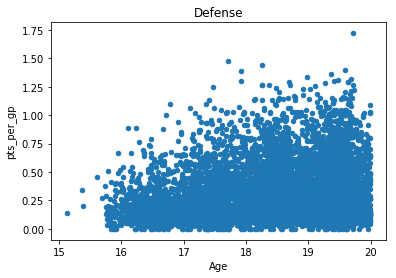

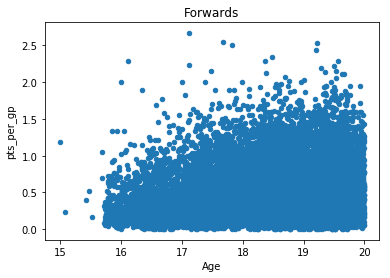

In [342]:
#graphing the correlation between age and points per game 
import matplotlib.pyplot as plt
ax1 = age_adj_def_df.plot(kind='scatter', x='Age', y='pts_per_gp')
ax2 = age_adj_fwd_df.plot(kind='scatter', x='Age', y='pts_per_gp')
ax1.set_title('Defense')
ax2.set_title('Forwards')
print(ax1)
print(ax2)

In [343]:
#getting the coef and yint of the linear regression for points age adj.
def_adj_model = linear_model.LinearRegression()
def_adj_model.fit(age_adj_def_df[['Age']].values, age_adj_def_df['pts_per_gp'].values)
def_model_coef = round(def_adj_model.coef_[0], 3)
def_model_yint = round(def_adj_model.intercept_, 3)
fwd_adj_model = linear_model.LinearRegression()
fwd_adj_model.fit(age_adj_fwd_df[['Age']].values, age_adj_fwd_df['pts_per_gp'].values)
fwd_model_coef = round(fwd_adj_model.coef_[0], 3)
fwd_model_yint = round(fwd_adj_model.intercept_, 3)

In [344]:
# subset main dataframe for only those players in their first draft year
draft_year_df = roster[roster['draft_year'] == 0]

In [345]:
#creating adjusted pts per game for forwards and defense
age_adj_def_df.loc[:,('age_adj_pts_g')] = (1- ((age_adj_def_df.loc[:,('Age')]-17) * def_model_coef)) \
                                        * age_adj_def_df.loc[:,('pts_per_gp')]
age_adj_fwd_df.loc[:,('age_adj_pts_g')] = (1- ((age_adj_fwd_df.loc[:,('Age')]-17) * def_model_coef)) \
                                        * age_adj_fwd_df.loc[:,('pts_per_gp')]

#(1 - ([Age as of September of draft year - 17] * 0.1672)) * Pts/GP as from Rhys Jessop formula

/Users/MattBarlowe/.virtualenvs/prospectmodel/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/MattBarlowe/.virtualenvs/prospectmodel/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [346]:
#concatting the fwds and def dataframes to join to the draft_year_df
frames = [age_adj_fwd_df, age_adj_def_df]
age_adj_total = pd.concat(frames)

In [347]:
draft_year_df = draft_year_df.merge(age_adj_total[['player_id', 'age_adj_pts_g', 'season']], 
                                    on=['player_id', 'season'])

In [348]:
draft_year_df = draft_year_df.fillna(value=0)


In [357]:
draft_year_df[draft_year_df['Player'] == 'Rasmus Dahlin']


,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,team_id,season,team,season_start,draft_cutoff,draft_cutoff_age,draft_year,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-,league,nhl_GP,nhl_G,nhl_A,nhl_TP,goals_to_points,pts_per_gp,age_adj_pts_g,50_plus_nhl_gp
3511,26,Rasmus Dahlin,17.44,D,2000-04-13,HC Lidköping,6.17,183,L,310545,12,2018,Frölunda HC,2017-09-15,2018-09-15,18.44,0,48,9,13,22,24,6,1,2,3,2,3,SHL,0.0,0,0,0,0.41,0.46,0.449273,0


In [351]:
from sklearn.model_selection import train_test_split
draft_year_df['50_plus_nhl_gp'] = np.where(draft_year_df['nhl_GP']>=50, 1, 0)

In [381]:

X_train, X_test, y_train, y_test = train_test_split(draft_year_df[[
                                                                   'GP', 'G', 'A', 'TP',
                                                                   'playoff_GP', 'playoff_G', 'playoff_A', 
                                                                   'playoff_TP',
                                                                   'goals_to_points', 'pts_per_gp', 'age_adj_pts_g']],
                                                    draft_year_df['50_plus_nhl_gp'], test_size=0.2)

In [382]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5107, 11) (5107,)
(1277, 11) (1277,)


In [383]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [384]:
predictions = logisticRegr.predict_proba(X_test)[:,1]


In [385]:
predict = logisticRegr.predict(X_test)

0.9130775254502741

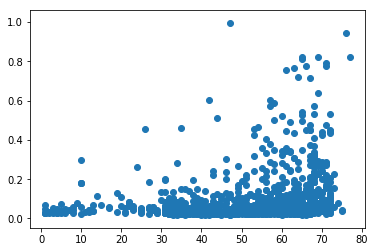

In [387]:
plt.scatter(X_test['GP'], predictions)
logisticRegr.score(X_test, y_test)

In [388]:
draft_2018_df = draft_year_df[draft_year_df['season']==2018]

In [389]:
draft_2018_df.head()

,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,team_id,season,team,season_start,draft_cutoff,draft_cutoff_age,draft_year,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-,league,nhl_GP,nhl_G,nhl_A,nhl_TP,goals_to_points,pts_per_gp,age_adj_pts_g,50_plus_nhl_gp
35,71,Jacob Ragnarsson,17.99,D,1999-09-23,SK Iron,6,176,L,304366,13,2018,Almtuna IS,2017-09-15,2018-09-15,18.99,0,47,4,9,13,24,5,0,0,0,6,-1,Allsvenskan,0.0,0,0,0,0.31,0.28,0.265308,0
36,10,David Lilja,17.66,C,2000-01-23,Bofors IK,5.92,168,L,287721,25,2018,BIK Karlskoga,2017-09-15,2018-09-15,18.66,0,37,3,5,8,33,0,0,0,0,0,0,Allsvenskan,0.0,0,0,0,0.38,0.22,0.212304,0
37,6,Martin Fehérváry,17.96,D,1999-10-06,SHK Hodonín,6.08,190,L,274991,31,2018,IK Oskarshamn,2017-09-15,2018-09-15,18.96,0,42,1,6,7,24,8,1,2,3,2,4,Allsvenskan,0.0,0,0,0,0.14,0.17,0.161350,0
38,5,Martin Fehérváry,17.96,D,1999-10-06,SHK Hodonín,6.08,190,L,274991,5,2018,HV71,2017-09-15,2018-09-15,18.96,0,1,0,0,0,0,0,0,0,0,0,0,SHL,0.0,0,0,0,0.00,0.00,0.161350,0
39,47,Christian Lindberg,17.05,D,2000-08-31,Värmdö HC,6.08,161,L,350782,31,2018,IK Oskarshamn,2017-09-15,2018-09-15,18.05,0,33,0,0,0,2,4,0,0,0,2,1,Allsvenskan,0.0,0,0,0,0.00,0.00,0.000000,0


In [392]:
predictions_2018 = logisticRegr.predict_proba(draft_2018_df[['GP', 'G', 'A', 'TP',
                                                             'playoff_GP', 'playoff_G', 'playoff_A', 'playoff_TP',
                                                             'goals_to_points', 'pts_per_gp', 'age_adj_pts_g']])[:,1]

In [393]:
draft_2018_df['50_game_probs'] = predictions_2018

/Users/MattBarlowe/.virtualenvs/prospectmodel/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [394]:
draft_2018_df.head()

,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,team_id,season,team,season_start,draft_cutoff,draft_cutoff_age,draft_year,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-,league,nhl_GP,nhl_G,nhl_A,nhl_TP,goals_to_points,pts_per_gp,age_adj_pts_g,50_plus_nhl_gp,50_game_probs
35,71,Jacob Ragnarsson,17.99,D,1999-09-23,SK Iron,6,176,L,304366,13,2018,Almtuna IS,2017-09-15,2018-09-15,18.99,0,47,4,9,13,24,5,0,0,0,6,-1,Allsvenskan,0.0,0,0,0,0.31,0.28,0.265308,0,0.040361
36,10,David Lilja,17.66,C,2000-01-23,Bofors IK,5.92,168,L,287721,25,2018,BIK Karlskoga,2017-09-15,2018-09-15,18.66,0,37,3,5,8,33,0,0,0,0,0,0,Allsvenskan,0.0,0,0,0,0.38,0.22,0.212304,0,0.032481
37,6,Martin Fehérváry,17.96,D,1999-10-06,SHK Hodonín,6.08,190,L,274991,31,2018,IK Oskarshamn,2017-09-15,2018-09-15,18.96,0,42,1,6,7,24,8,1,2,3,2,4,Allsvenskan,0.0,0,0,0,0.14,0.17,0.161350,0,0.039558
38,5,Martin Fehérváry,17.96,D,1999-10-06,SHK Hodonín,6.08,190,L,274991,5,2018,HV71,2017-09-15,2018-09-15,18.96,0,1,0,0,0,0,0,0,0,0,0,0,SHL,0.0,0,0,0,0.00,0.00,0.161350,0,0.030111
39,47,Christian Lindberg,17.05,D,2000-08-31,Värmdö HC,6.08,161,L,350782,31,2018,IK Oskarshamn,2017-09-15,2018-09-15,18.05,0,33,0,0,0,2,4,0,0,0,2,1,Allsvenskan,0.0,0,0,0,0.00,0.00,0.000000,0,0.022718


In [396]:
draft_2018_df = draft_2018_df.sort_values(['50_game_probs'], ascending=False)

In [397]:
draft_2018_df.head()

,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,team_id,season,team,season_start,draft_cutoff,draft_cutoff_age,draft_year,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-,league,nhl_GP,nhl_G,nhl_A,nhl_TP,goals_to_points,pts_per_gp,age_adj_pts_g,50_plus_nhl_gp,50_game_probs
1875,14,Andrei Svechnikov,17.48,RW,2000-03-26,"Barnaul, RUS",6.25,187,L,328556,865,2018,Barrie Colts,2017-09-15,2018-09-15,18.48,0,44,40,32,72,67,8,5,6,11,12,-1,OHL,0.0,0,0,0,0.56,1.64,1.598278,0,0.664043
3441,11,Filip Zadina,17.81,LW,1999-11-27,"Pardubice, CZE",6.08,192,L,236471,885,2018,Halifax Mooseheads,2017-09-15,2018-09-15,18.81,0,57,44,38,82,36,9,5,7,12,0,2,QMJHL,0.0,0,0,0,0.54,1.44,1.378181,0,0.601278
3427,90,Joseph Veleno,17.68,C,2000-01-13,"Montréal, QC, CAN",6.08,194,L,271713,883,2018,Drummondville Voltigeurs,2017-09-15,2018-09-15,18.68,0,33,16,32,48,22,10,5,6,11,10,-1,QMJHL,0.0,0,0,0,0.33,1.45,1.397742,0,0.574929
1926,44,Akil Thomas,17.72,C,2000-01-02,"Brandon, FL, USA",6,170,R,364033,2231,2018,Niagara IceDogs,2017-09-15,2018-09-15,18.72,0,68,22,59,81,36,10,5,6,11,6,-3,OHL,0.0,0,0,0,0.27,1.19,1.144590,0,0.548598
6306,2,Calen Addison,17.44,D,2000-04-11,"Brandon, MB, CAN",5.83,179,R,278861,793,2018,Lethbridge Hurricanes,2017-09-15,2018-09-15,18.44,0,68,11,54,65,53,16,7,12,19,20,-11,WHL,0.0,0,0,0,0.17,0.96,0.937613,0,0.534190


In [415]:
draft_2018_df[['Player', '50_game_probs']].groupby(['Player'], as_index=False).mean().sort_values(['Player'], ascending=True).iloc[:50,:]

,Player,50_game_probs
0,Adam Liska,0.094352
1,Adam McCormick,0.107053
2,Adam McMaster,0.081117
3,Adam Samuelsson,0.057028
4,Adrien Beraldo,0.024924
5,Aidan Brown,0.038484
6,Aidan Dudas,0.287969
7,Aidan Fulp,0.027348
8,Aidan Timmermans,0.027874
9,Akil Thomas,0.548598


In [403]:
draft_rankings_2018 = draft_2018_df[['Player', '50_game_probs']].groupby(['Player'], as_index=False).mean().sort_values(['50_game_probs'], ascending=False)

In [412]:
draft_rankings_2018[(draft_rankings_2018['Player']=='Brady Tkachuk')]

,Player,50_game_probs


In [410]:
draft_2018_df.head()

,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,team_id,season,team,season_start,draft_cutoff,draft_cutoff_age,draft_year,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-,league,nhl_GP,nhl_G,nhl_A,nhl_TP,goals_to_points,pts_per_gp,age_adj_pts_g,50_plus_nhl_gp,50_game_probs
1875,14,Andrei Svechnikov,17.48,RW,2000-03-26,"Barnaul, RUS",6.25,187,L,328556,865,2018,Barrie Colts,2017-09-15,2018-09-15,18.48,0,44,40,32,72,67,8,5,6,11,12,-1,OHL,0.0,0,0,0,0.56,1.64,1.598278,0,0.664043
3441,11,Filip Zadina,17.81,LW,1999-11-27,"Pardubice, CZE",6.08,192,L,236471,885,2018,Halifax Mooseheads,2017-09-15,2018-09-15,18.81,0,57,44,38,82,36,9,5,7,12,0,2,QMJHL,0.0,0,0,0,0.54,1.44,1.378181,0,0.601278
3427,90,Joseph Veleno,17.68,C,2000-01-13,"Montréal, QC, CAN",6.08,194,L,271713,883,2018,Drummondville Voltigeurs,2017-09-15,2018-09-15,18.68,0,33,16,32,48,22,10,5,6,11,10,-1,QMJHL,0.0,0,0,0,0.33,1.45,1.397742,0,0.574929
1926,44,Akil Thomas,17.72,C,2000-01-02,"Brandon, FL, USA",6,170,R,364033,2231,2018,Niagara IceDogs,2017-09-15,2018-09-15,18.72,0,68,22,59,81,36,10,5,6,11,6,-3,OHL,0.0,0,0,0,0.27,1.19,1.144590,0,0.548598
6306,2,Calen Addison,17.44,D,2000-04-11,"Brandon, MB, CAN",5.83,179,R,278861,793,2018,Lethbridge Hurricanes,2017-09-15,2018-09-15,18.44,0,68,11,54,65,53,16,7,12,19,20,-11,WHL,0.0,0,0,0,0.17,0.96,0.937613,0,0.534190


In [411]:
logisticRegr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [421]:
brady = roster[roster['Player']=='Brady Tkachuk']
brady

,#,Player,Age,Position,Birthdate,Birthplace,HT,WT,Shots,player_id,team_id,season,team,season_start,draft_cutoff,draft_cutoff_age,draft_year,GP,G,A,TP,PIM,playoff_GP,playoff_G,playoff_A,playoff_TP,playoff_PIM,playoff_+/-,league,nhl_GP,nhl_G,nhl_A,nhl_TP,goals_to_points,pts_per_gp
77878,27,Brady Tkachuk,18.01,C/LW,1999-09-16,"St. Louis, MO, USA",6.25,196,L,201473,633,2018,Boston Univ.,2017-09-15,2018-09-15,19.01,1,40,8,23,31,61,0,0,0,0,0,0,NCAA,0.0,0,0,0,0.26,0.78
109095,37,Brady Tkachuk,16.01,C/LW,1999-09-16,"St. Louis, MO, USA",6.25,196,L,201473,5156,2016,USNTDP Juniors,2015-09-15,2016-09-15,17.01,-1,32,4,4,8,36,0,0,0,0,0,0,USHL,0.0,0,0,0,0.50,0.25
109643,7,Brady Tkachuk,17.01,C/LW,1999-09-16,"St. Louis, MO, USA",6.25,196,L,201473,5156,2017,USNTDP Juniors,2016-09-15,2017-09-15,18.01,0,24,12,11,23,73,0,0,0,0,0,0,USHL,0.0,0,0,0,0.52,0.96


In [423]:
brady['Birthdate'] - brady['season_start'] 

77878    -6574 days
109095   -5843 days
109643   -6209 days
dtype: timedelta64[ns]

In [450]:
from datetime import datetime
birthday = datetime(1999, 9, 16, 12, 0, 0)
birthday2 = datetime(2017, 9, 13, 12, 0, 0)
print((birthday-birthday2).days/365)

-18.005479452054793


In [460]:
from dateutil.relativedelta import relativedelta
d1 = datetime.strptime('1999-09-16', "%Y-%m-%d")
d2 = datetime.strptime('2017-09-15', "%Y-%m-%d")
rdelta = relativedelta(d2, d1)
print('Age in years - ', rdelta.years)
print('Age in days - ', rdelta.days)
print(rdelta.years + (rdelta.days/365))

Age in years -  17
Age in days -  30
17.08219178082192
